## 1 Import both Iris and ionsphere datasets

### Important note: Functions are implemented seperately until section 5
Until section 5 I implemented all functions seperately, as just regular python functions. They have to be executed in the right order or with the right dummy data to test them and see the results. 

In section 5 I create a conformal predictor object based on the Nearest Neighbour conformity measure given in the coursework specification. 

### Notes about datasets

**Iris:**  
Each sample has 4 features describing sepal length, sepal width, petal length, and petal width of an
iris plant. There are three possible labels, Y = {0, 1, 2}.

**Ionsphere:**  
The file ionosphere.txt contains data collected by a radar system in Goose Bay, Labrador. This system consists of a co-phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts. Each line of this file represents one labelled sample with commaseparated features. The last number in the line describes the classification. “Good” (+1) radar returns are those showing evidence of some type of structure in the ionosphere. “Bad” (−1) returns are those that do not.

In [8]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load iris dataset
iris = load_iris()

# Load ionsphere dataset
samples_iono = np.genfromtxt("ionosphere.txt", delimiter=",", usecols=np.arange(34)) # Extract ionsphere samples
labels_iono = np.genfromtxt("ionosphere.txt", delimiter=",", usecols=34, dtype='int') # Extract ionsphere int labels

## 2 Split the datasets into training/test sets

In [9]:
# Split the datasets into training, test samples and labels
X_iono_train, X_iono_test, y_iono_train, y_iono_test = train_test_split(samples_iono, labels_iono, random_state=2708)
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(iris['data'], iris['target'], random_state=2708)

### Notes and testing of the datasets

In [7]:
print("Iono training X: ", X_iono_train.shape, "Iono training y: ", y_iono_train.shape, "Iono test X: ", X_iono_test.shape,"Iono test y: ", y_iono_test.shape,)

Iono training X:  (263, 34) Iono training y:  (263,) Iono test X:  (88, 34) Iono test y:  (88,)


In [79]:
print(X_iono_train)

[[ 1.0000e+00  0.0000e+00  3.8521e-01 ...  3.1128e-01 -1.9066e-01
   2.8794e-01]
 [ 1.0000e+00  0.0000e+00  8.1143e-01 ... -5.0000e-02  8.2143e-01
  -1.5143e-01]
 [ 1.0000e+00  0.0000e+00  9.6071e-01 ... -1.5000e-04  5.2099e-01
  -1.8200e-03]
 ...
 [ 0.0000e+00  0.0000e+00 -1.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 1.0000e+00  0.0000e+00  1.0000e+00 ... -6.3156e-01  1.0000e+00
  -6.5935e-01]
 [ 1.0000e+00  0.0000e+00  9.5882e-01 ... -1.0797e-01  9.3144e-01
  -6.8880e-02]]


In [8]:
print("iris training X: ", X_iris_train.shape, "iris training y: ", y_iris_train.shape, "iris test X: ", X_iris_test.shape,"iris test y: ", y_iris_test.shape,)

iris training X:  (112, 4) iris training y:  (112,) iris test X:  (38, 4) iris test y:  (38,)


## 3 Implement the 1-NN method
Implement the Nearest Neighbour method (i.e., the 1 Nearest Neighbours method). Run it on both datasets: train it on the training set and compute the number of errors it makes on the test set and the test error rate (the ratio of the number of errors to the size of the test set).

### 3.1 Implement euclidian distance function

Creating a python function that calculates the eulidian distance between two vectors that are passed as arguments.

In [13]:
import math
def euclidian_distance(inst1, inst2):
    v1 = np.array(inst1)
    v2 = np.array(inst2)
    variable_sum = 0
    if(v1.shape == v2.shape):
        for i in range(v1.shape[0]):
            variable_sum += (v1[i] - v2[i])**2
        return math.sqrt(variable_sum)
    else:
        return -1

v1 = [1, 2, 3, 4]
v2 = [5, 6, 7, 8]
euclidian_distance(v1,v2)

8.0

### 3.2 Implement 1-NN method

#### 3.2.1 Implement a method that returns an array of sample indices based on euclidian distance to test sample
This function creates an array "distances", loads the euclidian distance from the test sample to each sample in the dataset and then creates a new array "indices", which at first is just an array of integers up to the value of the size of the dataset. When the distances have been calculated, the function uses bubble sort to sort the distances and doing so also sort the indices. The function returns an array of sorted indices based on euclidian distance to the test sample.

##### 3.2.1.1 Trying a method that returns all distances
If this works as expected I'm going to implement a sorting algorithm that sorts the distances and indices.

In [11]:
# First create a simpler function that just returns the distances to test method I'm thinking of using.
def get_all_nearest_neighbors_distances(test_sample, training_set_samples):
    distances = []
    for train_sample in training_set_samples:
        distances.append(euclidian_distance(test_sample, train_sample))
    return distances

In [25]:
test_sample_iris = np.array([7.2, 2.7, 6.2, 1.8])
#print(np.array(X_iris_train[0]).shape)
#print(test_sample.shape)
distances = get_all_nearest_neighbors_distances(test_sample_iris, X_iris_train)
distances[:3]

[1.542724862054151, 5.095095681142799, 5.61871871515206]

##### 3.2.1.2 Implementing a sorting algorithm to sort the distances and their corresponding indices
The commented out part is the first version of this function - it used bubble sort to sort the distances. Since then I've swapped out bubble sort for quicksort as trying to compute the Ionosphere dataset error rate took too long because of the bubble sort running time. 

This version now implements a quicksort sorting method with two functions "partition" and "quicksort" itself which recursively sort the array of indices based on corresponding distance values.

In [19]:
def partition(arr, indices, low, high):
    i = low - 1
    pivot = arr[indices[high]]

    for j in range(low, high):
        if arr[indices[j]] <= pivot:
            i = i + 1
            indices[i], indices[j] = indices[j], indices[i]

    indices[i + 1], indices[high] = indices[high], indices[i + 1]
    return i + 1

def quicksort(arr, indices, low, high):
    if low < high:
        pi = partition(arr, indices, low, high)
        quicksort(arr, indices, low, pi - 1)
        quicksort(arr, indices, pi + 1, high)
        

def get_all_nearest_neighbors_indices(test_sample, training_set_samples):
    distances = [euclidian_distance(test_sample, train_sample) for train_sample in training_set_samples]
    indices = list(range(len(distances)))
    
    n = len(indices)
    quicksort(distances, indices, 0, n - 1)
    
    return indices


##### 3.2.1.3 Testing if the method returns the expected data
Calling the get_all_nearest_neighbors_indices function and printing out the corresponding training samples to check if they are in fact the nearest samples to the test sample.

In [27]:
import numpy as np
test_sample_iris = np.array([7.2, 2.7, 6.2, 1.8])
indices = get_all_nearest_neighbors_indices(test_sample_iris, X_iris_train)
print(indices)
for index in indices[:10]:
    print(X_iris_train[index])

[21, 43, 34, 109, 22, 25, 58, 50, 44, 97, 68, 7, 48, 53, 62, 85, 105, 83, 66, 33, 78, 20, 18, 59, 12, 106, 84, 38, 54, 98, 0, 70, 31, 26, 107, 111, 42, 14, 110, 41, 49, 28, 75, 35, 46, 64, 60, 100, 91, 94, 101, 19, 95, 36, 4, 6, 90, 24, 52, 103, 17, 104, 32, 9, 45, 69, 40, 86, 39, 99, 10, 92, 27, 47, 1, 79, 30, 3, 89, 16, 55, 108, 102, 71, 96, 81, 5, 88, 63, 93, 76, 67, 80, 74, 23, 72, 87, 65, 8, 29, 13, 57, 2, 11, 82, 73, 56, 37, 61, 15, 51, 77]
[7.3 2.9 6.3 1.8]
[7.4 2.8 6.1 1.9]
[7.1 3.  5.9 2.1]
[7.2 3.2 6.  1.8]
[6.7 2.5 5.8 1.8]
[7.6 3.  6.6 2.1]
[7.7 2.8 6.7 2. ]
[7.7 3.  6.1 2.3]
[6.8 3.2 5.9 2.3]
[6.5 3.  5.8 2.2]


#### 3.2.2 Attempting to test if the data returned by get_all_nearest_neighbors_indices is correct
Plotting the data with labels to see the values of the training samples. Because I printed out the 10 nearest neighbours of my test sample in the previous codebox, I now have a reference point to check if the samples are correctly "the nearest ones"

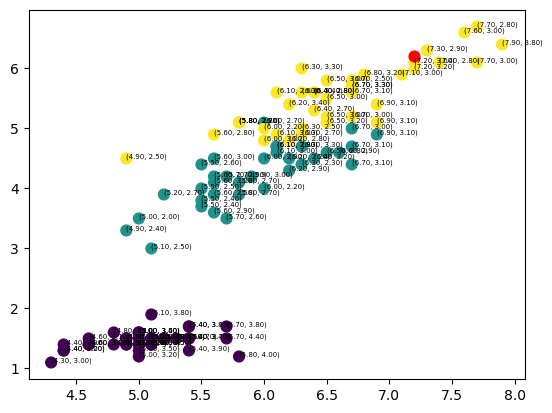

In [28]:
plt.scatter(X_iris_train[:, 0], X_iris_train[:, 2], c=y_iris_train, s=60)

plt.scatter(test_sample_iris[0], test_sample_iris[2], c='red', s=60) 

for x, y, label in zip(X_iris_train[:, 0], X_iris_train[:, 2], X_iris_train):
    plt.text(x, y, f'({label[0]:.2f}, {label[1]:.2f})', fontsize=5)


**Plotting results:** By plotting the samples like we did in the labs and adding labels to them I was able to add in my test sample into the plot and see if the array of nearest neighbors is correct by visually seing if the samples returned by my function are closest to the test sample in the plot. And testing out different values of a test_sample, it was always plotted around the 10 nearest samples printed out beforehand, so the results are accurate.

#### 3.2.3 Implementing the 1-NN method for iris dataset
Now that I've got a function that returns an array of indices for all the nearest neighbors of a given test sample, I can implement a function that predicts the label of an iris sample. The implementation is really easy as I just need to return the first corresponding label for the nearest index.

In [29]:
def predict_1nn(test_sample, training_set_samples, training_set_labels):
    nearest_neighbor_index = get_all_nearest_neighbors_indices(test_sample, training_set_samples)[0]
    nearest_label = training_set_labels[nearest_neighbor_index]
    return nearest_label

prediction = predict_1nn(test_sample_iris, X_iris_train, y_iris_train)
print(prediction)
print(iris['target_names'][prediction])

2
virginica


The prediction has succesfuly returned a value 2 which corresponds to a label virginica for the iris. Later on I'm going to compare the prediction results to the sklearn nearest-neighbour algorithm to see if mine performs similarly.

In [30]:
test_sample_iris_one = np.array([4.3, 3.,  1.1, 0.1])
test_sample_iris_two = np.array([6.,  2.2, 4.,  1. ])
test_sample_iris_three = np.array([7.2, 2.7, 6.2, 1.8])
prediction1 = predict_1nn(test_sample_iris_one, X_iris_train, y_iris_train)
prediction2 = predict_1nn(test_sample_iris_two, X_iris_train, y_iris_train)
prediction3 = predict_1nn(test_sample_iris_three, X_iris_train, y_iris_train)
print(prediction1, prediction2, prediction3)

0 1 2


This was me testing out if three different samples would get three different predictions.

#### 3.2.4 Evaluating the 1-NN model for the iris dataset
Testing what the accuracy of our prediction is by computing labels for the test test.

In [44]:
# MY 1-NN ALGORITHM
y_prediction_set = []
for sample in X_iris_test:
    y_prediction_set.append(predict_1nn(sample, X_iris_train, y_iris_train))
errors = 0
for i, label in enumerate(y_prediction_set):
    if(y_prediction_set[i] != y_iris_test[i]):
        errors = errors + 1
test_error_rate = errors/len(y_prediction_set) *100
print("Number of errors my algorithm: ",errors)
print("Test error rate my algorithm: ",test_error_rate, "%")

# SKLEARN 1-NN ALGORITHM
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_iris_test, y_iris_test)
y_prediction_set = knn.predict(X_iris_test)    
print(f"Test error rate sklearn: {(1-knn.score(X_iris_test,y_iris_test))*100}%")


Number of errors my algorithm:  3
Test error rate my algorithm:  7.894736842105263 %
Test error rate sklearn: 0.0%


**Evaluation result:** Our model had three incorrectly labelled samples which means the model has a test_error_rate of 7.89% 

#### 3.2.5 Testing if all previous functions work for the ionosphere dataset

In [45]:
test_sample_iono = X_iono_test[0]
#euclidian_distance(test_sample_iono, X_iono_train[4]) Works as expected
#get_all_nearest_neighbors_distances(test_sample_iono, X_iono_train) Works as expected
#indices = get_all_nearest_neighbors_indices(test_sample_iono, X_iono_train) Works as expected
#prediction = predict_1nn(test_sample_iono, X_iono_train, y_iono_train) Works as expected


#### 3.2.6 Evaluating 1-NN model for ionosphere dataset

In [46]:
y_prediction_set = []
for sample in X_iono_test:
    y_prediction_set.append(predict_1nn(sample, X_iono_train, y_iono_train))

errors = 0
for i, label in enumerate(y_prediction_set):
    if(y_prediction_set[i] != y_iono_test[i]):
        errors = errors + 1
    
test_error_rate = errors/len(y_prediction_set) *100
print("Number of errors: ",errors)
print("Test error rate: ",test_error_rate, "%")

Number of errors:  11
Test error rate:  12.5 %


## 4 Implement the conformal predictor
Implement the conformal predictor based on the Nearest Neighbour conformity measure:

(the distance to the nearest sample of a different class) / (the distance to the nearest sample of the same class)

### 4.1 Implement function that returns index of nearest label of either same or different class
The function will go through the array "training_indices" which will be passed to the function and return the first sample that matches (or doesn't) the class of the test_sample.

In [47]:
def get_nearest_label_index(index_of_sample, test_label, training_set_labels, training_indices, same_class = True):
    if(same_class):
        for index in training_indices:
            if(training_set_labels[index] == test_label):
                if(index_of_sample != index):
                    return index

    else:
        for index in training_indices:
            if(training_set_labels[index] != test_label):
                if(index_of_sample != index):
                    return index

#### 4.1.1 Testing the result of the get_nearest_label_index function

In [48]:
nearest_neighbor_indices_iris = get_all_nearest_neighbors_indices(test_sample_iris, X_iris_train)
nearest_neighbor_indices_iono = get_all_nearest_neighbors_indices(test_sample_iono, X_iono_train)
nearest_same_class_iris = X_iris_train[get_nearest_label_index(9999, 1, y_iris_train, nearest_neighbor_indices_iris)]
nearest_same_class_iono = X_iono_train[get_nearest_label_index(9999, 1, y_iono_train, nearest_neighbor_indices_iono)]
nearest_diff_class_iris = X_iris_train[get_nearest_label_index(9999, 1, y_iris_train, nearest_neighbor_indices_iris, False)]
nearest_diff_class_iono = X_iono_train[get_nearest_label_index(9999, 1, y_iono_train, nearest_neighbor_indices_iono, False)]
print(nearest_same_class_iris)
print(nearest_same_class_iono)
print(nearest_diff_class_iris)
print(nearest_diff_class_iono)

[6.7 3.  5.  1.7]
[ 1.       0.       0.8811   0.       0.94817 -0.02744  0.93598 -0.0122
  0.90244  0.01829  0.90244  0.01829  0.93902  0.00915  0.95732  0.00305
  1.       0.02744  0.94207 -0.0122   0.90854  0.02439  0.91463  0.05488
  0.99695  0.04878  0.89666  0.02226  0.90854  0.00915  1.       0.05488
  0.97561 -0.0122 ]
[7.3 2.9 6.3 1.8]
[ 1.       0.       0.62745 -0.07843  0.72549  0.       0.60784 -0.07843
  0.62745 -0.11765  0.68627 -0.11765  0.66667 -0.13725  0.64706 -0.09804
  0.54902 -0.11765  0.54902 -0.21569  0.58824 -0.19608  0.66667 -0.23529
  0.45098 -0.2549   0.52409 -0.24668  0.56863 -0.31373  0.43137 -0.21569
  0.47059 -0.27451]


### 4.2 Implementing function that calculates nonconformity scores
The function will add the test sample and each possible postulated label to the training set and by doing so create augmented training sets for labels and samples. We can then calculate each samples nonconformity score and store it in an array "nonconformity_scores".

**Note** I know the corsework specification mentions "conformity measure" not "nonconformity measure", but after running tests, the error rate was 7 times higher implementing this algorithm thinking about the scores as conformity scores, not nonconformity scores, so I have decided to use those as they provide more accurate results.

In [58]:
def get_scores(label, test_sample, training_set_samples, training_set_labels):
    augmented_labels = np.append(training_set_labels, label)
    augmented_samples = np.append(training_set_samples, [test_sample], axis=0)
    nonconformity_scores = []
    for index, sample in enumerate(augmented_samples):
        nearest_neighbor_indices = get_all_nearest_neighbors_indices(sample, augmented_samples)
        nearest_same = augmented_samples[get_nearest_label_index(index, augmented_labels[index], augmented_labels, nearest_neighbor_indices)]
        nearest_diff = augmented_samples[get_nearest_label_index(index, augmented_labels[index], augmented_labels, nearest_neighbor_indices, False)]
        distance_same = euclidian_distance(sample, nearest_same)
        distance_diff = euclidian_distance(sample, nearest_diff)
        if(distance_diff != 0):
            nonconformity_scores.append(distance_same/distance_diff)
        else:
            nonconformity_scores.append(math.inf)

    return nonconformity_scores

test_label = 1
scores = get_scores(test_label, test_sample_iono, X_iono_train, y_iono_train)
scores[:10]

[1.2050411933348806,
 0.3262124536870392,
 0.5312394890232827,
 0.2674094277110743,
 0.6495506043426897,
 0.9491000115088472,
 1.3873459023470434,
 0.9224959289196489,
 0.4526306318300297,
 0.2609441822246603]

### 4.3 Implementing a function that returns the p-value of a test sample
The function takes just one argument "nonconformity_scores" which is an array of nonconformity scores for the augmented training set. It then calculates how many scores are higher or equal than the last score (the last score is the test sample) and returns that value divided by n+1

In [59]:
def get_p_value(nonconformity_scores):
    test_score = nonconformity_scores[-1]
    count = sum(score >= test_score for score in nonconformity_scores[:-1]) + 1
    return count / len(nonconformity_scores)

label_space_iris = [0,1,2]
label_space_iono = [1, -1]

for label in label_space_iris: 
    scores_iris = get_scores(label, test_sample_iris, X_iris_train, y_iris_train)
    p_value_iris = get_p_value(scores_iris)
    print(f"P-value for label: {label} on sample: {test_sample_iris} is {p_value_iris}")
    
for label in label_space_iono: 
    scores_iono = get_scores(label, test_sample_iono, X_iono_train, y_iono_train)
    p_value_iono = get_p_value(scores_iono)
    print(f"P-value for label: {label} on test sample is {p_value_iono}")

    

P-value for label: 0 on sample: [7.2 2.7 6.2 1.8] is 0.008849557522123894
P-value for label: 1 on sample: [7.2 2.7 6.2 1.8] is 0.008849557522123894
P-value for label: 2 on sample: [7.2 2.7 6.2 1.8] is 0.584070796460177
P-value for label: 1 on test sample is 0.9090909090909091
P-value for label: -1 on test sample is 0.003787878787878788


### 4.4 Implementing the predict function
The predict function will actually predict the label based on the previously calculated p_values and the possible labels. 

In [60]:
def predict(test_sample, training_set_samples, training_set_labels, label_space):
    highest = 0
    predicted_label = -2
    for label in label_space:
        nononformity_scores = get_scores(label, test_sample, training_set_samples, training_set_labels)
        p_value = get_p_value(nononformity_scores)
        if p_value > highest:
            highest = p_value
            predicted_label = label
    return predicted_label

In [61]:
iris_possible_labels = [0,1,2]
iono_possible_labels = [1, -1]

test_sample_iris = np.array([7.2, 2.7, 6.2, 1.8]) 
test_sample_iono = np.array(X_iono_test[0]) 

prediction_iris = predict(test_sample_iris, X_iris_train, y_iris_train, iris_possible_labels)
prediction_iono = predict(test_sample_iono, X_iono_train, y_iono_train, iono_possible_labels)

print(f"My prediction for test_sample_iris: {iris['target_names'][prediction_iris]}")
print(f"My prediction for test_sample_iono: {prediction_iono}")

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_iono_train, y_iono_train)

test_sample_iono_nn = np.array([X_iono_test[0]]) 
prediction_iono = knn.predict(test_sample_iono_nn)
print(f"sklearn NN algorithm prediction for test_sample_iono: {prediction_iono}")

knn.fit(X_iris_train, y_iris_train)

test_sample_iris_nn = np.array([[7.2, 2.7, 6.2, 1.8]]) 
prediction_iris = knn.predict(test_sample_iris_nn)
print(f"sklearn NN algorithm prediction for test_sample_iris: {iris['target_names'][prediction_iris]}")


My prediction for test_sample_iris: virginica
My prediction for test_sample_iono: 1
sklearn NN algorithm prediction for test_sample_iono: [1]
sklearn NN algorithm prediction for test_sample_iris: ['virginica']


### 4.5 Evaluating conformal predictor
Evaluating the conformal predictor by calculating the error amount and rate, and then calculating the average false p-value.

#### 4.5.1 Evaluating error amount and rate

In [62]:
iono_possible_labels = [-1,1]
predictions_iono = []
for sample in X_iono_test:
    predictions_iono.append(predict(sample, X_iono_train, y_iono_train, iono_possible_labels))

# iris_possible_labels = [0,1,2]
# predictions_iris = []
# for sample in X_iris_test:
#     predictions_iris.append(predict(sample, X_iris_train, y_iris_train, iris_possible_labels))
    
# Compare with actual labels to calculate error rate
errors_iono = sum(predicted_label != actual_label for predicted_label, actual_label in zip(predictions_iono, y_iono_test))
error_rate_iono = errors_iono / len(y_iono_test) * 100

# # Compare with actual labels to calculate error rate
# errors_iris = sum(predicted_label != actual_label for predicted_label, actual_label in zip(predictions_iris, y_iris_test))
# error_rate_iris = errors_iris / len(y_iris_test) * 100

print(f"Error amount in iono: {errors_iono}")
print(f"Error rate in iono: {error_rate_iono}%")
# print(f"Error amount in iris: {errors_iris}")
# print(f"Error rate in iris: {error_rate_iris}%")

Error amount in iono: 11
Error rate in iono: 12.5%


#### 4.5.1 Calculating average false p-value
A function that creates an array "false_p_values" and stores all of the incorrectly predicted label p-values. It then just calculates the average of those values and returns it.

In [66]:
def calculate_avg_false_p_value(X_test, y_test, X_train, Y_train, label_space):
    false_p_values = []
    for i in range(len(X_test)):
        test_sample = X_test[i]
        true_label = y_test[i]
        predicted_label = predict(test_sample, X_train, Y_train, label_space)
        nonconformity_scores = get_scores(predicted_label, test_sample, X_train, Y_train)
        test_score = nonconformity_scores[-1]
        p_value = get_p_value(nonconformity_scores)
        if predicted_label != true_label:
            false_p_values.append(p_value)
    avg_false_p_value = np.mean(false_p_values)
    return avg_false_p_value

iris_possible_labels = [0,1,2]
iono_possible_labels = [-1, 1]

avg_false_p_value_iris = calculate_avg_false_p_value(X_iris_test, y_iris_test, X_iris_train, y_iris_train, iris_possible_labels)
print(f"Average false p-value for iris: {avg_false_p_value_iris}")

avg_false_p_value_iono = calculate_avg_false_p_value(X_iono_test, y_iono_test, X_iono_train, y_iono_train, iono_possible_labels)
print(f"Average false p-value for iono: {avg_false_p_value_iono}")

Average false p-value for iris: 0.11504424778761063
Average false p-value for iono: 0.2617079889807163


## 5 Turning the individual functions into a conformal predictor object
All of the functions used as the object fuctions work and are structured the same way as the previously described and executed functikons are, the only difference for most of them is not having the training sets as arguments as those are stored in the object itself.

### 5.1 Creating NN_conformal_predictor object

In [65]:
import math
class NN_conformal_predictor:
    def __init__(self, X, y):
        '''NN_predictor constructor'''
        self.X_train = X
        self.y_train = y
        self.label_space = list(set(y))
        
    
    def _euclidian_distance(self, inst1, inst2):
        '''Calculate euclidian distance between two rows in the dataset'''
        v1 = np.array(inst1)
        v2 = np.array(inst2)
        variable_sum = 0
        if(v1.shape == v2.shape):
            for i in range(v1.shape[0]):
                variable_sum += (v1[i] - v2[i])**2
            return math.sqrt(variable_sum)
        else:
            return -1
        
    def _partition(self, arr, indices, low, high):
        i = low - 1
        pivot = arr[indices[high]]

        for j in range(low, high):
            if arr[indices[j]] <= pivot:
                i = i + 1
                indices[i], indices[j] = indices[j], indices[i]

        indices[i + 1], indices[high] = indices[high], indices[i + 1]
        return i + 1

    def _quicksort(self, arr, indices, low, high):
        if low < high:
            pi = self._partition(arr, indices, low, high)
            self._quicksort(arr, indices, low, pi - 1)
            self._quicksort(arr, indices, pi + 1, high)

    def _get_all_nearest_neighbors_indices(self, test_sample):
        distances = [self._euclidian_distance(test_sample, train_sample) for train_sample in self.X_train]
        indices = list(range(len(distances)))

        n = len(indices)
        self._quicksort(distances, indices, 0, n - 1)

        return indices
    
    def predict_1nn(self, test_sample):
        '''1-NN Predictor, returns label of the nearest neighbour'''
        nearest_neighbor_index = self._get_all_nearest_neighbors_indices(test_sample)[0]
        nearest_label = self.y_train[nearest_neighbor_index]
        return nearest_label
    
    def _get_nearest_label_index(self, test_sample, test_label, index_of_sample, same_class = True):
        '''Returns index of nearest neighbour with same class label as test sample'''
        training_indices = self._get_all_nearest_neighbors_indices(test_sample)
        if(same_class):
            for index in training_indices:
                if(self.y_train[index] == test_label):
                    if(index_of_sample != index):
                        return index
        else:
            for index in training_indices:
                if(self.y_train[index] != test_label):
                    if(index_of_sample != index):
                        return index
                    
    def _get_scores(self, test_sample, test_label):
        '''Returns array of augmented training sets nonconformity scores'''
        self.X_train = np.append(self.X_train, [test_sample], axis=0)
        self.y_train = np.append(self.y_train, test_label)
        nononformity_scores = []
        for index, sample in enumerate(self.X_train):
            nearest_neighbor_indices = self._get_all_nearest_neighbors_indices(sample)
            nearest_same = self.X_train[self._get_nearest_label_index(sample, self.y_train[index], index)]
            nearest_diff = self.X_train[self._get_nearest_label_index(sample, self.y_train[index], index, False)]
            distance_same = self._euclidian_distance(sample, nearest_same)
            distance_diff = self._euclidian_distance(sample, nearest_diff)
            if(distance_diff != 0):
                nononformity_scores.append(distance_same/distance_diff)
            else:
                nononformity_scores.append(math.inf)
        self.X_train = self.X_train[:-1]
        self.y_train = self.y_train[:-1]
        return nononformity_scores
    
    def _get_p_value(self, test_sample, test_label):
        '''Returns p-value of test_sample with test_label'''
        nononformity_scores = self._get_scores(test_sample, test_label)
        test_score = nononformity_scores[-1]
        count = sum(score >= test_score for score in nononformity_scores[:-1]) + 1
        return count / len(nononformity_scores)
    
    def predict(self, test_sample):
        '''Returns predicted label for test_sample'''
        highest = 0
        predicted_label = math.inf
        for label in self.label_space:
            p_value = self._get_p_value(test_sample, label)
            if p_value > highest:
                highest = p_value
                predicted_label = label
        return predicted_label
    
    def get_error_amount(self, y_test, predictions):
        errors = y_test != predictions
        return np.sum(errors)
                    
    def get_error_rate(self, y_test, predictions):
        errors = y_test != predictions
        return (np.sum(errors)/y_test.shape[0]) * 100
        

predictor = NN_conformal_predictor(X_iris_train, y_iris_train)
x_new = np.array([7.2, 2.7, 6.2, 1.8])
y_new = 2
print(predictor._get_p_value(x_new, y_new))
print(predictor.predict(x_new))

0.584070796460177
2


### 5.2 Evaluating the conformal predictor object
Evaluating the error amount and rate that the conformal predictor gives on the iris and ionosphere datasets. Then as it has been taking quite long to get results also measuring what the running time of the prediction is.

#### 5.2.1 Evaluating error amount and rate in conformal predictor object (Conformal prediciton)

In [70]:
import time
predictor_iris = NN_conformal_predictor(X_iris_train, y_iris_train)
predictor_iono = NN_conformal_predictor(X_iono_train, y_iono_train)

start_time_iris = time.time()
predictions_iris = [predictor_iris.predict(sample) for sample in X_iris_test]
errors_iris = predictor_iris.get_error_amount(y_iris_test, predictions_iris)
error_rate_iris = predictor_iris.get_error_rate(y_iris_test, predictions_iris)
print(f"The nonconformal predictor on the iris test dataset had {errors_iris} errors, which gives us an error rate of {error_rate_iris}%")
end_time_iris = time.time()

start_time_iono = time.time()
predictions_iono = [predictor_iono.predict(sample) for sample in X_iono_test]
errors_iono = predictor_iono.get_error_amount(y_iono_test, predictions_iono)
error_rate_iono = predictor_iono.get_error_rate(y_iono_test, predictions_iono)
print(f"The nonconformal predictor on the Ionospehere test dataset had {errors_iono} errors, which gives us an error rate of {error_rate_iono}%")
end_time_iono = time.time()

The nonconformal predictor on the iris test dataset had 2 errors, which gives us an error rate of 5.263157894736842%
The nonconformal predictor on the Ionospehere test dataset had 11 errors, which gives us an error rate of 12.5%


#### 5.2.2 Evaluating error amount and rate as well as running time in conformal predictor object (1-NN prediction)


In [76]:
import time
predictor_iris = NN_conformal_predictor(X_iris_train, y_iris_train)

start_time_iris = time.time()
predictions_iris = [predictor_iris.predict_1nn(sample) for sample in X_iris_test]
errors_iris = predictor_iris.get_error_amount(y_iris_test, predictions_iris)
error_rate_iris = predictor_iris.get_error_rate(y_iris_test, predictions_iris)
print(f"The nonconformal predictor object (using 1-NN) on the iris test dataset had {errors_iris} errors, which gives us an error rate of {error_rate_iris}%")
end_time_iris = time.time()
execution_time_iris = end_time_iris - start_time_iris
print(f"The running time of the 1-NN algorithm is {execution_time_iris}s")

The nonconformal predictor object (using 1-NN) on the iris test dataset had 3 errors, which gives us an error rate of 7.894736842105263%
The running time of the 1-NN algorithm is 0.017100095748901367s


#### 5.2.3 Evaluating running time of conformal predictor and comparing it to sklearn's algorithm

In [71]:
import time
from sklearn.neighbors import KNeighborsClassifier
knn_iris = KNeighborsClassifier(n_neighbors=1)
knn_iono = KNeighborsClassifier(n_neighbors=1)

start_time_iris_sklearn = time.time()
knn_iris.fit(X_iris_train, y_iris_train)
knn_iris.score(X_iris_test, y_iris_test)
end_time_iris_sklearn = time.time()

start_time_iono_sklearn = time.time()
knn_iono.fit(X_iono_train, y_iono_train)
knn_iono.score(X_iono_test, y_iono_test)
end_time_iono_sklearn = time.time()

execution_time_iris = end_time_iris - start_time_iris
execution_time_iono = end_time_iono - start_time_iono
execution_time_iris_sklearn = end_time_iris_sklearn - start_time_iris_sklearn
execution_time_iono_sklearn = end_time_iono_sklearn - start_time_iono_sklearn
print(f"Execution time for my conformal predictor algorithm on iris dataset: {execution_time_iris} seconds")
print(f"Execution time for my conformal predictor algorithm on ionosphere dataset: {execution_time_iono} seconds")
print(f"Execution time for sklearn predictor algorithm on iris dataset: {execution_time_iris_sklearn} seconds")
print(f"Execution time for sklearn predictor algorithm on ionosphere dataset: {execution_time_iono_sklearn} seconds")



Execution time for my conformal predictor algorithm on iris dataset: 7.861454010009766 seconds
Execution time for my conformal predictor algorithm on ionosphere dataset: 294.37130904197693 seconds
Execution time for sklearn predictor algorithm on iris dataset: 0.06001114845275879 seconds
Execution time for sklearn predictor algorithm on ionosphere dataset: 0.021790027618408203 seconds


#### Evaluation results
The amount of errors and error rate for both the ionosphere and iris datasets are really good in my opinion. Having an error rate of 5.2% and 12.5% leaves us with accuracy of 94.8% and 87.5%.

Of course the error rate could be lower, especially for the ionosphere dataset, but for the fact that we have used such a simple nonconformity measure and still gotten a relatively high accuracy surprised me. 